In [ ]:
import os 
import numpy as np 
import cv2
from pdf2image import convert_from_path
import pytesseract
import unicodedata
import re
import pandas as pd
import natsort
import matplotlib.pyplot as plt
import spellchecker
import fuzzywuzzy 
pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'

# SpellChecker en français
spell = spellchecker.SpellChecker(language='fr')

current_dir = os.getcwd()


pd.set_option("display.max_rows", None)      # Show all rows
pd.set_option("display.max_columns", None)   # Show all columns
pd.set_option("display.width", 0)            # Auto-detect width
pd.set_option("display.max_colwidth", None)  # Don't truncate column content


100
Levenshtein installé : True


In [28]:
# Extracts the year from the filename after 'Thèses_'.
def extract_year_from_filename(filename):
    # Regex pattern to match both formats
    match = re.search(r'Theses_(\d{4})(?:_(\d{4}))?_(\d+)_(\d+|blank)(?:\.pdf)?$', filename)
    
    # If no match is found, return None or handle as needed
    if not match:
        return None

    # Extract the year and check if there's a second year
    year = match.group(1)
    second_year = match.group(2)  # This will be None if there's no second year
    start = match.group(3)
    end = match.group(4)

    # If a second year exists, concatenate it with the first year
    if second_year:
        year = f"{year}_{second_year}"

    return (year, int(start), end)

In [29]:
#Checks if a page is blank 
def is_blank(image, threshold=0.99):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    height = gray.shape[0]
    
    # Crops the 10% at the bottom of the page so that the number of the page doesn't affect our analysis
    cropped_gray = gray[:int(0.9 * height), :]
    
    _, thresh = cv2.threshold(cropped_gray, 240, 255, cv2.THRESH_BINARY)
    white_ratio = np.sum(thresh == 255) / thresh.size
    
    return white_ratio > threshold  # Retourne True si la page est blanche

In [30]:
# Converts a PDF file into images, saving each page as a PNG.
# # Images are stored in the specified output folder.
def convert_pdf_to_images(pdf_path, output_folder, start_page, end_page):
    images = convert_from_path(pdf_path)
    if end_page =='blank' :
        images = images[start_page:] 
    else : 
        end_page = int(end_page)
        images = images[start_page:end_page]  

    for i, image in enumerate(images):
        image_path = os.path.join(output_folder, f"page_{i+1}.png")
        image.save(image_path, "PNG")

        if is_blank(image):
            break

In [31]:
# Processes all PDFs in the input directory.
# Extracts the year from the filename and creates a subfolder for each year.
# Converts each PDF into images and stores them in the corresponding subfolder.
def process_all_pdfs(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # Ensure the parent directory exists
    
    for filename in os.listdir(input_dir):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(input_dir, filename)  # Full path to PDF
            year, start_page, end_page = extract_year_from_filename(filename)
            if not year or year == "Erreur":  # Skip if invalid year extracted
                continue

            output_folder = os.path.join(output_dir, year)
            os.makedirs(output_folder, exist_ok=True)  # Ensure the subfolder is created
            
            convert_pdf_to_images(pdf_path, output_folder,start_page,end_page)



In [32]:
# Define the input and output paths relative to the current directory
input_dir = os.path.join(current_dir, '..', 'data', 'pdf_Tables_theses_Paris_1870_1939')  # Relative path to 'lib/data/pdf_Tables_theses_Paris_1870_1939'
output_dir = os.path.join(current_dir, '..', 'data', 'pdfs_en_images_png')  # Output path within 'lib/data/pdfs_en_images_png'

os.makedirs(output_dir, exist_ok = True)

process_all_pdfs(input_dir, output_dir)

FIN DE LA TRANSFORMATION EN PNG DES FICHIERS;
DEBUT DE L'EXTRACTIION ET DU TRAITEMENT DU TEXTE.

























In [33]:
def detect_all_tome_positions(image):
    data = pytesseract.image_to_data(image, lang='fra', output_type=pytesseract.Output.DICT)
    tome_positions = []

    for i, text in enumerate(data["text"]):
        clean = text.strip().upper()
        if not clean:
            continue
        if clean == "TOME" or re.search(r'\bTOME\s+\w+\b', clean):
            y = data["top"][i]
            h = data["height"][i]
            tome_positions.append((y, h))

    return sorted(tome_positions, key=lambda x: x[0])  # tri par ordre vertical


In [34]:
def split_by_tome_markers(image, positions):
    slices = []
    prev_y = 0

    for y, h in positions:
        cut_y = y + h
        slices.append(image[prev_y:cut_y, :])
        prev_y = cut_y

    # Dernier segment (jusqu'en bas)
    slices.append(image[prev_y:, :])
    return slices

In [35]:
def extract_columns(image):
    (h, w) = image.shape
    left = image[:, :w//2 - 5]
    right = image[:, 5 + w//2:]    

    left_text = pytesseract.image_to_string(left, lang='fra')
    right_text = pytesseract.image_to_string(right, lang='fra')
    return left_text + " " + right_text


In [36]:
def process_image(image, first):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    if first:
        gray = gray[580:, :]

    tome_positions = detect_all_tome_positions(gray)

    if tome_positions:
        horizontal_slices = split_by_tome_markers(gray, tome_positions)
        full_text = ""

        for i, slice_img in enumerate(horizontal_slices):
            text = extract_columns(slice_img)
            full_text += f"--- Segment {i+1} ---\n{text}\n\n"

        return full_text
    else:
        return extract_columns(gray)

In [37]:
def extract_informations(text, year):

    pattern = re.compile(r"([A-ZÉÀÈÙÂÊÎÔÛÄËÏÖÜÇ]{2,}) \(([^)]+)\)\. (.+)?")

    # Initialisation des variables
    data = []
    current_nom = None
    current_prenom = None
    current_sujet = ""        
    current_year = year             

    lines = text.split("\n")

    for line in lines:
        line = line.strip()  
        
        match = pattern.match(line)  

        if match:
            if current_nom is not None:
                data.append([current_nom, current_prenom, current_sujet.strip(),current_year])

            current_nom = match.group(1)
            current_prenom = match.group(2)
            current_sujet = match.group(3) if match.group(3) else ""
        
        else:
            if current_nom is not None:
                current_sujet += " " + line  

    if current_nom is not None:
        data.append([current_nom, current_prenom, current_sujet.strip(), current_year])

    df_cleaned = pd.DataFrame(data, columns=["Nom", "Prénom", "Sujet","year"])

    return df_cleaned

In [38]:
def process_folder(input_dir,year):
    text = ""  
    df = pd.DataFrame()
  
    
    for image_file in natsort.natsorted(os.listdir(input_dir)):
        image_path = os.path.join(input_dir, image_file)
        image = cv2.imread(image_path)
        if image_file.lower().endswith('.png'): 
            if  image_file == "page_1.png" : 
                first = True 
            else : first = False
            text = text + process_image(image, first)
    df = extract_informations(text,year)
    return df

In [39]:
def remove_accents(text):
    if isinstance(text, str):
        return ''.join(
            c for c in unicodedata.normalize('NFD', text)
            if unicodedata.category(c) != 'Mn'
        )
    return text

In [40]:
def cleanup_up_subject_column(df) :
    df['Nom'] = df['Nom'].astype(str)
    df['Prénom'] = df['Prénom'].astype(str)
    df['Sujet'] = df['Sujet'].astype(str)
    df['Sujet'] = df['Sujet'].str.replace('- ', '', regex=False)
    df['Sujet'] = df['Sujet'].str.replace(r',?\s*\d+\s*', ' ', regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r'\s+', ' ', regex=True).str.strip() 
    df['Sujet'] = df['Sujet'].str.replace(r"([bcdfghjklmnpqrstvwxyz]) (?=[aeiouy])", r"\1", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"[\"'#%&*\[\]{}<>|\\/^¤§°@=+\~`]", "", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"[•●▪■♦◊¤§°@©®™‰¨«»„”“†‡‚‘’]", " ", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"\b[a-zA-Z]\b", "", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"\b(TOM|TON|H|U|UVIL|co|tu|ot|mw|vf|En|El|N)\b", "", regex=True, flags=re.IGNORECASE)
    df['Sujet'] = df['Sujet'].str.replace(r"\s*[\.,;:!?]\s*", ". ", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"\s+", " ", regex=True).str.strip()
    df['Sujet'] = df['Sujet'].apply(remove_accents)
    df['Prénom'] = df['Prénom'].apply(remove_accents)

In [41]:
def rescue_missing_entries(df):
    """
    Looks for names accidentally merged into the 'Sujet' field,
    and splits them out into new rows.
    """
    rescue_pattern = re.compile(
        r"\b([A-ZÉÀÈÙÂÊÎÔÛÄËÏÖÜÇ]{2,})[ ,]*([A-ZÉÀÈÙÂÊÎÔÛÄËÏÖÜÇa-zéàèùâêîôûäëïöüç\-]+)\)?[ .,-]"
    )

    rescued_rows = []

    for idx, sujet in df["Sujet"].items():
        matches = list(rescue_pattern.finditer(sujet))

        if matches:
            match = matches[0]
            start = match.start()
            rescued_text = sujet[start:]
            original_subject = sujet[:start].strip()

            # Update current row's Sujet
            df.at[idx, "Sujet"] = original_subject

            # Create rescued row
            nom = match.group(1)
            prenom = match.group(2)
            sujet_rescue = rescued_text[len(match.group(0)):].strip()

            rescued_rows.append({
                "Nom": nom,
                "Prénom": prenom,
                "Sujet": sujet_rescue
            })

    if rescued_rows:
        df_rescue = pd.DataFrame(rescued_rows)
        df = pd.concat([df, df_rescue], ignore_index=True)

    return df


In [42]:
def process_all_folders(input_dir) : 
    df= pd.DataFrame(columns=["Nom", "Prénom", "Sujet", "year"])

    for year_folder in natsort.natsorted(os.listdir(input_dir)):
        year_path = os.path.join(input_dir, year_folder) 
        print(year_folder)        
        if os.path.isdir(year_path):  # Check if it's a directory
            df = pd.concat((df, process_folder(year_path, year_folder)), ignore_index= True)
            rescue_missing_entries(df)
            cleanup_up_subject_column(df)

    return df

In [ ]:
input_dir = os.path.join(current_dir, '..', 'data', 'test')  # Relative path to 'lib/data/pdfs_en_images_png'

df1 = process_all_folders(input_dir)
print(df1.to_string(max_rows=250, max_cols=210))


FIN  DE L'EXTRACTION DE TEXTE ET CORRECTIONS MINEURES D'OCR. 
DEBUT DU TRAITEMENT DE TEXTE : 
PRECISION ET CORRECTION DE L'OCR (DICTIONNAIRE FRANCAIS ET MEDICAL)
Corriger les mots faux de l ocrisation a l aide des dictionnaires: 
tu pourrais envisager une correction automatique OCR après reconnaissance (spellchecker français + médical).

Exemples de librairies :

pyspellchecker
fuzzywuzzy pour match flous avec ton francais.txt
NLTK : Natural Language Tool Documentation (). https://www.nltk.org/.

Une fois que la correction est faire refaire test de precision


In [44]:
input_dir = input_dir = os.path.join(current_dir, '..', 'data', 'Dictionnaires')  # Relative path to 'lib/data/pdfs_en_images_png'

# Chargement + nettoyage du dictionnaire français
with open(os.path.join(input_dir, 'francais.txt'), encoding="utf-8") as f:
    dico_fr = set(remove_accents(line.strip().lower()) for line in f if line.strip())

with open(os.path.join(input_dir, 'medical.txt'), encoding="utf-8") as f:
    dico_med = set(remove_accents(line.strip().lower()) for line in f if line.strip())

In [ ]:
def compter_mots(text, dico_fr, dico_med):
    if not isinstance(text, str) or not text.strip():
        return 0, 0
    mots = re.findall(r'\b\w+\b', text.lower())  # Découpe en mots
    total = len(mots)
    corrects = sum(1 for mot in mots if mot in dico_fr or (dico_med and mot in dico_med))
    return corrects, total


In [ ]:
def calculer_precision_OCR(df, dico_fr, dico_med):
    # Applique la fonction 'compter_mots' sur chaque ligne de 'Sujet'
    df[['Mots corrects', 'Mots totaux']] = df['Sujet'].apply(lambda x: pd.Series(compter_mots(x, dico_fr, dico_med)))

    # Regroupement par année
    df2 = df.groupby('year').agg({'Mots corrects': 'sum', 'Mots totaux': 'sum'}).reset_index()

    # Calcul du total global
    total_row = pd.DataFrame({
        'year': ['Total'],
        'Mots corrects': [df2['Mots corrects'].sum()],
        'Mots totaux': [df2['Mots totaux'].sum()]
    })

    # Ajout de la ligne Total
    df2 = pd.concat([df2, total_row], ignore_index=True)

    return df2

    year  Mots corrects  Mots totaux
0   1870           1083         1496
1  Total           1083         1496


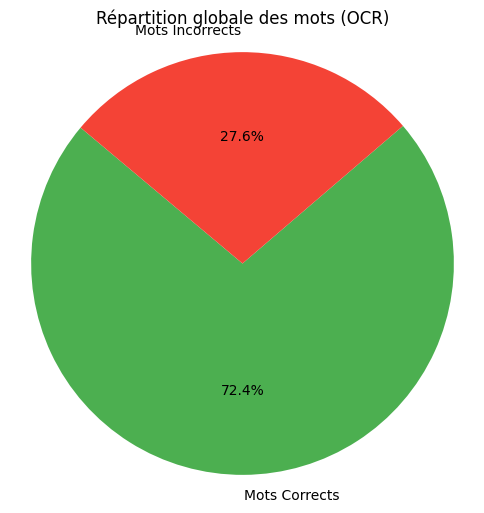

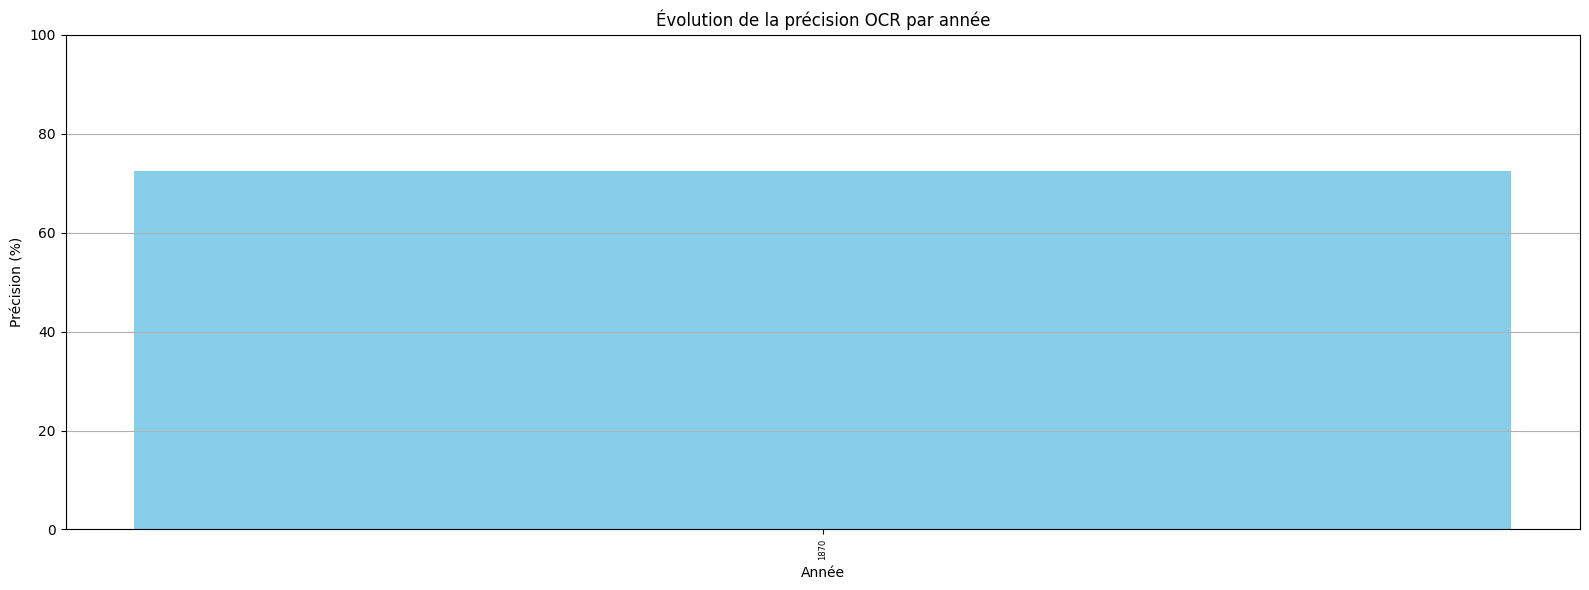

In [47]:
def afficher_précision(df1, dico_fr, dico_med) :
    df2 = calculer_precision_OCR(df1, dico_fr, dico_med)
    df2 = calculer_precision_OCR(df1, dico_fr, dico_med)
    print(df2.to_string(max_rows=1000000, max_cols=5))
    df2['Precision (%)'] = df2['Mots corrects'] / df2['Mots totaux'] * 100

    total_correct = df2.loc[df2['year'] == 'Total', 'Mots corrects'].values[0]
    total_words = df2.loc[df2['year'] == 'Total', 'Mots totaux'].values[0]
    total_incorrect = total_words - total_correct

    labels = ['Mots Corrects', 'Mots Incorrects']
    sizes = [total_correct, total_incorrect]
    colors = ['#4CAF50', '#F44336']

    plt.figure(figsize=(6,6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Répartition globale des mots (OCR)')
    plt.axis('equal')  
    plt.show()

    df2_years_only = df2[df2['year'] != 'Total']

    plt.figure(figsize=(16,6))
    plt.bar(df2_years_only['year'], df2_years_only['Precision (%)'], color='skyblue')
    plt.title('Évolution de la précision OCR par année')
    plt.xlabel('Année')
    plt.ylabel('Précision (%)')
    plt.grid(axis='y')
    plt.xticks(rotation=90, fontsize=6)  # ← rotation 90° pour les années
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    return df2

df2 = afficher_précision(df1, dico_fr, dico_med)


RECONNAISSANCE DU SEXE (DICTIONNAIRE DES PRENOMS) Dictionnaires pour pouvoir reconnaitre hommes femmes (dictionnaire de prénoms + rajouter ceux d'amelie puche) + remplir case sexe du csv + mettre case résolu vrai ou faux si la ligne a un prénom reconnu avec un sexe reconnu 
elle est résolu sinon il faut la résoudre
Reconnaitre hommes et femme et mettre infos dans csv + categorie pas sur ou prenoms double sexe ect sur lesquels il faudra faire des recherches specifiques et rentrer manuellement dans les csv ou 
Prénom mixte sans madame ou mademoiselle camille problématique recherche dans université paris cité
Marie est un piège car masculin a la fin du 19eme siècle
Marie compose peut être homme. donc tous les marie sont dans la categorie pas sur 

Nombre de femmmes vs nombre d'hommes total puis par annee et faire des graphes 